In [1]:
# Install libraries for data_loader
!pip install pandas
!pip install sklearn
!pip install torchvision
!pip install tqdm
!pip install torchmetrics

In [75]:
# Import DataLoader and corresponding libraries
import pandas
import torchvision.transforms as TT
from torch.utils.data import DataLoader, Dataset, sampler
from sklearn.model_selection import StratifiedKFold
from torchvision import utils
from PIL import Image

In [76]:
# Import libraries for tensors
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [77]:
# For fbeta-score
from torchmetrics.functional import fbeta_score

In [78]:
# For model construction
from collections import OrderedDict

In [79]:
# Import tqdm for progress bar construction
import tqdm

In [80]:
# from google.colab import drive
# drive.mount('/content/gdrive')

# Datatypes and Devices (from Assignment 2)
dtype = torch.float
ltype = torch.long

if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cpu


In [81]:
# Hyper-parameters for K-Fold Cross Validation
N = 5
seed = 42

# Directories for Data
FF1010_Path = './data/'
AudioImage_Path = './image/'

In [82]:
# Call StratifiedKFold object
skf = StratifiedKFold(
    n_splits=5, shuffle=True, random_state=seed
)

In [83]:
# Modify dataframe for K-Fold Cross Validation (birdclef2021)
birdclef_csv = pandas.read_csv(AudioImage_Path + 'train_metadata.csv')
birdclef_csv.loc[birdclef_csv['label_id'] >= 0,'filepath'] = \
    AudioImage_Path + birdclef_csv.query('label_id >= 0')['primary_label'] + '/' + \
    birdclef_csv.query('label_id >= 0')['filename'] + '.npy'

birdclef_csv = birdclef_csv.dropna()
birdclef_csv = birdclef_csv.reset_index(drop=True)

# Add 'fold' attribute for dataset classification
birdclef_dataframe = birdclef_csv.copy()
for n, (_, nth_groups) in enumerate(
    skf.split(birdclef_dataframe, birdclef_dataframe['label_id'])):
    birdclef_dataframe.loc[nth_groups, 'fold'] = int(n)

In [84]:
# Class for ff1010 dataset
class birdclef(Dataset):
    def __init__(self, dataframe, process='train', labels='label_id'):
        self.dataframe = dataframe
        self.filepaths = dataframe['filepath'].values
        self.labels = dataframe[labels].values
        self.process = process
        
        # Transforms for each train and validation
        self.train_transform = TT.Compose([
            TT.Resize([128, 281]),
            TT.RandomHorizontalFlip(p=0.5),
            TT.RandomVerticalFlip(p=0.5),
            TT.ToTensor(),
            TT.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
        ])
        self.val_transform = TT.Compose([
            TT.Resize([128, 281]),
            TT.ToTensor(),
            TT.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
        ])
    
    def __getitem__(self, idx):
        source = np.load(self.filepaths[idx])
        
        # Rearrange numpy arrays
        source = source.transpose(1, 2, 0)
        
        # Add RGB dimension
        source = np.stack((np.squeeze(source), ) * 3, -1)
        if len(source.shape) == 3:
            source = np.expand_dims(source, axis=2)
        source = source.transpose(2, 0, 1, 3)
        N, H, W, C = source.shape
        
        # Apply transform
        if self.process == 'train':
            source = torch.stack([self.train_transform(Image.fromarray(x)) for x in source])
        elif self.process == 'valid':
            source = torch.stack([self.val_transform(Image.fromarray(x)) for x in source])
        
        # Select the middle input from slices
        source = source[N // 2]

        return source, torch.tensor(self.labels[idx], dtype=ltype)
    
    def __len__(self):
        return len(self.dataframe)

In [85]:
def evaluate_model(loader, model, beta=1.0):
    print("Checking accuracy score on validation set.")
    # TODO: extend this so that we can print that we evaluate test set.
    num_correct = 0
    num_samples = 0
    log_sum = 0
    fbeta_sum = 0
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=torch.float)
            y = y.to(device=device, dtype=torch.long)
            y = torch.squeeze(y, 0)
            scores = model(torch.squeeze(x, 0))
            # scores means classfication class for each class. It should be the tensor with size of (Input size, Number of classes)

            # Checks naive accuracy.
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)

            # Checks Log Loss.
            log_loss = F.cross_entropy(scores, y)
            log_sum += log_loss.sum() * preds.size(0)

            # Checks Fbeta-score.
            fbeta = fbeta_score(preds, y, beta=beta)
            fbeta_sum += fbeta * preds.size(0)
            
            # Erase memory caches
            del x, y, scores, log_loss
        
        acc = float(num_correct) / num_samples
        log_score = log_sum / num_samples
        f_score = fbeta_sum / num_samples
        print('\nAccuracy: %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
        print('Log Loss score:\t%.2f' % (log_score))
        print('Fbeta-score (beta=%d): \t%.2f' % (beta , f_score))
    return acc, log_score, f_score

In [92]:
import os

# Print period for accuracy.
print_period = 100

# Hyper-parameters for training 
birdclef_batch = 16
birdclef_epoch = 20

# Learning Rate.
learning_rate_1 = 0.0001

# L2 Regularization Hyperparamter
weight_decay_1 = 0.001

# Beta constant for Fbeta-score.
# If you want to give more weight to precision, use value smaller than 1.0.
# If you want to give more weight to recall, use value larger than 1.0.
beta = 1.0

# Prototype of model 2.
# ResNet50 outputs (Batchsize, 1000) tensor as output, so we reduce them to 397.
class Model2(nn.Module):
    def __init__(self, num_classes=397):
        super().__init__()
#        self.resnet50 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True).to(device)
        self.googlenet = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=True).to(device)
        self.relu = nn.ReLU().to(device)
        self.linear = nn.Linear(1000, num_classes, bias=True).to(device)
    
    def forward (self, x):
#        x = self.resnet50(x)
        x = self.googlenet(x)
        x = self.relu(x)
        x = self.linear(x)
        return x

cur_model = Model2()
print(cur_model)

def checkpoint(model, optimizer, loss, epoch, index):
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss
            }, './bird_specificator_googlenet.pt')

def train_model(model, train_loader, val_loader, optimizer, scheduler, beta=beta, epoch=birdclef_epoch):
    val_losses = []
    train_losses = []
    epoch_losses = []
    log_scores = []
    fbeta_scores = []
    
    loss = 0
    log_score = 0
    saved_epoch = -1
    
    # Load checkpoint
    
    
    for e in range(epoch):
        if e < saved_epoch:
            continue
        
        if len(val_losses) == 0 and saved_epoch > -1:
            acc, log_score, fbeta_score = evaluate_model(val_loader, model, beta=beta)
            val_losses.append(acc)
            train_losses.append(torch.tensor(sum(epoch_losses) / len(epoch_losses), dtype=dtype))
            log_scores.append(log_score)
            fbeta_scores.append(fbeta_score)
            
        print(f"Training model 2, epoch {e+1}")
        for index, (source, label) in enumerate(tqdm.tqdm(train_loader)):          
            x = source.to(device=device, dtype=torch.float)  # move to device, e.g. GPU
            y = label.to(device=device, dtype=torch.long)
            y = torch.squeeze(y, 0)

            scores = model(torch.squeeze(x, 0))
            loss = F.cross_entropy(scores, y) # Log loss for our project.

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())

            # every print_period, print loss.
            if index % print_period == 0:
                print('Iteration %d, loss = %.4f' % (index, loss.item()))
                
            # Erase memory caches
            del source, label, x, y, scores, loss
            
        # Cosine LR Annealing Scheduler
        scheduler.step()
        
        # every epoch, save the model
        checkpoint(model, optimizer, epoch_losses, e, index)
        
        # Append the score to lists
        acc, log_score, fbeta_score = evaluate_model(val_loader, model, beta=beta)
        val_losses.append(acc)
        train_losses.append(torch.tensor(sum(epoch_losses) / len(epoch_losses), dtype=dtype))
        log_scores.append(log_score)
        fbeta_scores.append(fbeta_score)

    return model, val_losses, train_losses, log_scores, fbeta_scores

Model2(
  (googlenet): GoogLeNet(
    (conv1): BasicConv2d(
      (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (conv2): BasicConv2d(
      (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv3): BasicConv2d(
      (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (inception3a): Inception(
      (branch1): BasicConv2d(
        (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): 

Using cache found in C:\Users\ujubo/.cache\torch\hub\pytorch_vision_v0.10.0


In [93]:
# Train loop for bird specificator
def bird_train(model, train_dataframe, val_dataframe, test_dataframe):  
    train_data = birdclef(train_dataframe, process='train', labels='label_id')
    val_data = birdclef(val_dataframe, process='valid', labels='label_id')
    test_data = birdclef(test_dataframe, process='valid', labels='label_id')
    
    # Construct data loader for train and validation
    train_loader = DataLoader(train_data, batch_size=birdclef_batch,
                             sampler=sampler.SubsetRandomSampler(range(len(train_dataframe))), 
                             drop_last=True)
    val_loader = DataLoader(val_data, batch_size=birdclef_batch,
                             sampler=sampler.SubsetRandomSampler(range(len(val_dataframe))),
                             drop_last=False)
    test_loader = DataLoader(test_data, batch_size=birdclef_batch,
                              sampler=sampler.SubsetRandomSampler(range(len(test_dataframe))),
                              drop_last=False)
    
#    optimizer = optim.Adam(model.parameters(), lr=learning_rate_2)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate_1, momentum=0.5, weight_decay=weight_decay_1)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=birdclef_epoch, eta_min=1e-5)
    trained_model, val_losses, train_losses, log_scores, fbeta_scores = train_model(
        model, train_loader, val_loader, optimizer, scheduler, beta=beta)
    test_acc, test_log_score, test_fbeta_score = evaluate_model(test_loader, trained_model, beta=beta)
    
    return val_losses, train_losses, log_scores, fbeta_scores, [test_acc, test_log_score, test_fbeta_score]

In [94]:
# Train, Validate and Test for nocall detector
def bird(model, dataframe, val_index, test_index):
    
    # Check that validation fold is not same as test fold
    assert val_index != test_index, \
        'Validation and test should be done on different fold.'
    print('Test set : %d, Validation set : %d' % (test_index, val_index))
    
    train_dataframe = dataframe.query(
        'fold != ' + str(val_index) + ' and fold != ' + str(test_index) 
    ).reset_index(drop=True)
    val_dataframe = dataframe.query(
        'fold == ' + str(val_index) 
    ).reset_index(drop=False)
    test_dataframe = dataframe.query(
        'fold == ' + str(test_index) 
    ).reset_index(drop=False)
    
    val_losses, train_losses, log_scores, fbeta_scores, test_scores = bird_train(
        model, train_dataframe, val_dataframe, test_dataframe)

    return val_losses, train_losses, log_scores, fbeta_scores, test_scores

In [95]:
val_losses, train_losses, log_scores, fbeta_scores, test_scores = \
    bird(cur_model, birdclef_dataframe, 1, 0)
del cur_model

# for i in range(2, 5):
#     cur_model = Model2()
#     cv_losses, ctr_losses, cl_scores, cf_scores, cte_scores = nocall(cur_model, birdclef_dataframe, i, 0)
#     val_losses = torch.mean(torch.stack((torch.tensor(val_losses), torch.tensor(cv_losses))), dim=0)
#     train_losses = torch.mean(torch.stack((torch.tensor(train_losses), torch.tensor(ctr_losses))), dim=0)
#     log_scores = torch.mean(torch.stack((torch.tensor(log_scores), torch.tensor(cl_scores))), dim=0)
#     fbeta_scores = torch.mean(torch.stack((torch.tensor(fbeta_scores), torch.tensor(cf_scores))), dim=0)
#     for j in range(len(test_scores)):
#         test_scores[j] = torch.mean(torch.stack((torch.tensor(test_scores[j]), torch.tensor(cte_scores[j]))), dim=0)

Test set : 0, Validation set : 1
Training model 2, epoch 1


  0%|                                                                                 | 1/2357 [00:00<38:12,  1.03it/s]

Iteration 0, loss = 6.1800


  4%|███▍                                                                           | 101/2357 [01:47<40:13,  1.07s/it]

Iteration 100, loss = 6.0731


  9%|██████▋                                                                        | 201/2357 [03:31<36:45,  1.02s/it]

Iteration 200, loss = 5.9440


 13%|██████████                                                                     | 301/2357 [05:15<37:08,  1.08s/it]

Iteration 300, loss = 6.2418


 17%|█████████████▍                                                                 | 401/2357 [07:00<35:53,  1.10s/it]

Iteration 400, loss = 6.1368


 21%|████████████████▊                                                              | 501/2357 [08:45<32:20,  1.05s/it]

Iteration 500, loss = 6.1006


 25%|████████████████████▏                                                          | 601/2357 [10:30<30:59,  1.06s/it]

Iteration 600, loss = 6.1630


 30%|███████████████████████▍                                                       | 701/2357 [12:17<28:25,  1.03s/it]

Iteration 700, loss = 6.0843


 34%|██████████████████████████▊                                                    | 801/2357 [14:07<28:06,  1.08s/it]

Iteration 800, loss = 6.1180


 38%|██████████████████████████████▏                                                | 901/2357 [15:57<27:08,  1.12s/it]

Iteration 900, loss = 5.9713


 42%|█████████████████████████████████▏                                            | 1001/2357 [17:47<25:53,  1.15s/it]

Iteration 1000, loss = 6.0670


 47%|████████████████████████████████████▍                                         | 1101/2357 [19:38<22:57,  1.10s/it]

Iteration 1100, loss = 6.1599


 51%|███████████████████████████████████████▋                                      | 1201/2357 [21:29<20:49,  1.08s/it]

Iteration 1200, loss = 6.1330


 55%|███████████████████████████████████████████                                   | 1301/2357 [23:18<19:06,  1.09s/it]

Iteration 1300, loss = 6.1184


 59%|██████████████████████████████████████████████▎                               | 1401/2357 [25:09<17:15,  1.08s/it]

Iteration 1400, loss = 5.7908


 64%|█████████████████████████████████████████████████▋                            | 1501/2357 [26:59<15:50,  1.11s/it]

Iteration 1500, loss = 6.1689


 68%|████████████████████████████████████████████████████▉                         | 1601/2357 [28:48<13:42,  1.09s/it]

Iteration 1600, loss = 6.0328


 72%|████████████████████████████████████████████████████████▎                     | 1701/2357 [30:37<11:48,  1.08s/it]

Iteration 1700, loss = 5.9326


 76%|███████████████████████████████████████████████████████████▌                  | 1801/2357 [32:26<10:11,  1.10s/it]

Iteration 1800, loss = 5.9884


 81%|██████████████████████████████████████████████████████████████▉               | 1901/2357 [34:16<08:16,  1.09s/it]

Iteration 1900, loss = 6.1826


 85%|██████████████████████████████████████████████████████████████████▏           | 2001/2357 [36:05<06:13,  1.05s/it]

Iteration 2000, loss = 5.8823


 89%|█████████████████████████████████████████████████████████████████████▌        | 2101/2357 [37:55<04:43,  1.11s/it]

Iteration 2100, loss = 6.1680


 93%|████████████████████████████████████████████████████████████████████████▊     | 2201/2357 [39:45<02:46,  1.06s/it]

Iteration 2200, loss = 5.9130


 98%|████████████████████████████████████████████████████████████████████████████▏ | 2301/2357 [41:38<01:03,  1.13s/it]

Iteration 2300, loss = 6.0141


100%|██████████████████████████████████████████████████████████████████████████████| 2357/2357 [42:40<00:00,  1.09s/it]


Checking accuracy score on validation set.

Accuracy: 76 / 12575 correct (0.60)
Log Loss score:	5.98
Fbeta-score (beta=1): 	0.01
Training model 2, epoch 2


  0%|                                                                                 | 1/2357 [00:01<57:58,  1.48s/it]

Iteration 0, loss = 6.0178


  4%|███▍                                                                           | 101/2357 [01:52<42:51,  1.14s/it]

Iteration 100, loss = 6.1810


  9%|██████▋                                                                        | 201/2357 [03:43<40:51,  1.14s/it]

Iteration 200, loss = 5.9274


 13%|██████████                                                                     | 301/2357 [05:34<38:17,  1.12s/it]

Iteration 300, loss = 6.1671


 17%|█████████████▍                                                                 | 401/2357 [07:26<34:26,  1.06s/it]

Iteration 400, loss = 5.8963


 21%|████████████████▊                                                              | 501/2357 [09:18<34:16,  1.11s/it]

Iteration 500, loss = 5.9088


 25%|████████████████████▏                                                          | 601/2357 [11:09<32:35,  1.11s/it]

Iteration 600, loss = 5.9894


 30%|███████████████████████▍                                                       | 701/2357 [12:59<30:01,  1.09s/it]

Iteration 700, loss = 6.0931


 34%|██████████████████████████▊                                                    | 801/2357 [14:49<28:42,  1.11s/it]

Iteration 800, loss = 5.8930


 38%|██████████████████████████████▏                                                | 901/2357 [16:38<26:51,  1.11s/it]

Iteration 900, loss = 5.9188


 42%|█████████████████████████████████▏                                            | 1001/2357 [18:30<25:36,  1.13s/it]

Iteration 1000, loss = 5.9081


 47%|████████████████████████████████████▍                                         | 1101/2357 [20:23<23:15,  1.11s/it]

Iteration 1100, loss = 5.9344


 51%|███████████████████████████████████████▋                                      | 1201/2357 [22:15<20:57,  1.09s/it]

Iteration 1200, loss = 6.0345


 55%|███████████████████████████████████████████                                   | 1301/2357 [24:05<19:22,  1.10s/it]

Iteration 1300, loss = 5.6864


 59%|██████████████████████████████████████████████▎                               | 1401/2357 [25:55<17:37,  1.11s/it]

Iteration 1400, loss = 5.7655


 64%|█████████████████████████████████████████████████▋                            | 1501/2357 [27:46<15:37,  1.10s/it]

Iteration 1500, loss = 5.7085


 68%|████████████████████████████████████████████████████▉                         | 1601/2357 [29:37<13:49,  1.10s/it]

Iteration 1600, loss = 5.7592


 72%|████████████████████████████████████████████████████████▎                     | 1701/2357 [31:26<12:15,  1.12s/it]

Iteration 1700, loss = 5.8624


 76%|███████████████████████████████████████████████████████████▌                  | 1801/2357 [33:18<10:58,  1.18s/it]

Iteration 1800, loss = 5.8197


 81%|██████████████████████████████████████████████████████████████▉               | 1901/2357 [35:09<08:27,  1.11s/it]

Iteration 1900, loss = 5.8814


 85%|██████████████████████████████████████████████████████████████████▏           | 2001/2357 [36:58<06:37,  1.12s/it]

Iteration 2000, loss = 5.5377


 89%|█████████████████████████████████████████████████████████████████████▌        | 2101/2357 [38:48<04:39,  1.09s/it]

Iteration 2100, loss = 5.6783


 93%|████████████████████████████████████████████████████████████████████████▊     | 2201/2357 [40:37<02:51,  1.10s/it]

Iteration 2200, loss = 5.6584


 98%|████████████████████████████████████████████████████████████████████████████▏ | 2301/2357 [42:27<01:00,  1.08s/it]

Iteration 2300, loss = 5.8756


100%|██████████████████████████████████████████████████████████████████████████████| 2357/2357 [43:29<00:00,  1.11s/it]


Checking accuracy score on validation set.

Accuracy: 136 / 12575 correct (1.08)
Log Loss score:	5.83
Fbeta-score (beta=1): 	0.01
Training model 2, epoch 3


  0%|                                                                                 | 1/2357 [00:01<47:59,  1.22s/it]

Iteration 0, loss = 5.6388


  4%|███▍                                                                           | 101/2357 [01:51<41:03,  1.09s/it]

Iteration 100, loss = 6.0180


  9%|██████▋                                                                        | 201/2357 [03:43<41:17,  1.15s/it]

Iteration 200, loss = 5.9410


 13%|██████████                                                                     | 301/2357 [05:33<39:36,  1.16s/it]

Iteration 300, loss = 6.2104


 17%|█████████████▍                                                                 | 401/2357 [07:32<37:35,  1.15s/it]

Iteration 400, loss = 5.7102


 21%|████████████████▊                                                              | 501/2357 [09:32<37:42,  1.22s/it]

Iteration 500, loss = 5.8484


 25%|████████████████████▏                                                          | 601/2357 [11:42<37:10,  1.27s/it]

Iteration 600, loss = 5.7568


 30%|███████████████████████▍                                                       | 701/2357 [13:46<32:50,  1.19s/it]

Iteration 700, loss = 5.7947


 34%|██████████████████████████▊                                                    | 801/2357 [15:54<35:25,  1.37s/it]

Iteration 800, loss = 5.9657


 38%|██████████████████████████████▏                                                | 901/2357 [18:04<28:58,  1.19s/it]

Iteration 900, loss = 5.7435


 42%|█████████████████████████████████▏                                            | 1001/2357 [20:11<27:27,  1.22s/it]

Iteration 1000, loss = 6.0063


 47%|████████████████████████████████████▍                                         | 1101/2357 [22:18<27:38,  1.32s/it]

Iteration 1100, loss = 5.5365


 51%|███████████████████████████████████████▋                                      | 1201/2357 [24:28<24:13,  1.26s/it]

Iteration 1200, loss = 5.7436


 55%|███████████████████████████████████████████                                   | 1301/2357 [26:31<21:09,  1.20s/it]

Iteration 1300, loss = 6.0527


 59%|██████████████████████████████████████████████▎                               | 1401/2357 [28:35<19:37,  1.23s/it]

Iteration 1400, loss = 5.6229


 64%|█████████████████████████████████████████████████▋                            | 1501/2357 [30:42<17:32,  1.23s/it]

Iteration 1500, loss = 5.7701


 68%|████████████████████████████████████████████████████▉                         | 1601/2357 [32:44<15:29,  1.23s/it]

Iteration 1600, loss = 6.0018


 72%|████████████████████████████████████████████████████████▎                     | 1701/2357 [34:51<13:21,  1.22s/it]

Iteration 1700, loss = 5.8193


 76%|███████████████████████████████████████████████████████████▌                  | 1801/2357 [36:53<11:11,  1.21s/it]

Iteration 1800, loss = 5.5963


 81%|██████████████████████████████████████████████████████████████▉               | 1901/2357 [38:56<09:46,  1.29s/it]

Iteration 1900, loss = 5.5687


 85%|██████████████████████████████████████████████████████████████████▏           | 2001/2357 [41:03<07:39,  1.29s/it]

Iteration 2000, loss = 6.0278


 89%|█████████████████████████████████████████████████████████████████████▌        | 2101/2357 [43:07<05:20,  1.25s/it]

Iteration 2100, loss = 5.6841


 93%|████████████████████████████████████████████████████████████████████████▊     | 2201/2357 [45:09<02:58,  1.14s/it]

Iteration 2200, loss = 5.6244


 98%|████████████████████████████████████████████████████████████████████████████▏ | 2301/2357 [47:05<01:03,  1.13s/it]

Iteration 2300, loss = 5.9097


100%|██████████████████████████████████████████████████████████████████████████████| 2357/2357 [48:09<00:00,  1.23s/it]


Checking accuracy score on validation set.

Accuracy: 196 / 12575 correct (1.56)
Log Loss score:	5.76
Fbeta-score (beta=1): 	0.02
Training model 2, epoch 4


  0%|                                                                                 | 1/2357 [00:01<50:23,  1.28s/it]

Iteration 0, loss = 5.7012


  4%|███▍                                                                           | 101/2357 [02:12<50:32,  1.34s/it]

Iteration 100, loss = 6.1226


  9%|██████▋                                                                        | 201/2357 [04:24<46:07,  1.28s/it]

Iteration 200, loss = 5.9644


 13%|██████████                                                                     | 301/2357 [06:37<47:39,  1.39s/it]

Iteration 300, loss = 5.7594


 17%|█████████████▍                                                                 | 401/2357 [08:45<43:09,  1.32s/it]

Iteration 400, loss = 5.8986


 21%|████████████████▊                                                              | 501/2357 [11:00<41:51,  1.35s/it]

Iteration 500, loss = 5.6718


 25%|████████████████████▏                                                          | 601/2357 [13:20<43:18,  1.48s/it]

Iteration 600, loss = 5.9199


 30%|███████████████████████▍                                                       | 701/2357 [15:41<38:42,  1.40s/it]

Iteration 700, loss = 5.7182


 34%|██████████████████████████▊                                                    | 801/2357 [18:02<38:12,  1.47s/it]

Iteration 800, loss = 5.9020


 38%|██████████████████████████████▏                                                | 901/2357 [20:25<34:11,  1.41s/it]

Iteration 900, loss = 5.7853


 42%|█████████████████████████████████▏                                            | 1001/2357 [22:44<31:29,  1.39s/it]

Iteration 1000, loss = 5.8336


 47%|████████████████████████████████████▍                                         | 1101/2357 [25:01<28:27,  1.36s/it]

Iteration 1100, loss = 5.8020


 51%|███████████████████████████████████████▋                                      | 1201/2357 [27:15<24:32,  1.27s/it]

Iteration 1200, loss = 5.7743


 55%|███████████████████████████████████████████                                   | 1301/2357 [29:29<22:12,  1.26s/it]

Iteration 1300, loss = 5.5770


 59%|██████████████████████████████████████████████▎                               | 1401/2357 [31:41<21:23,  1.34s/it]

Iteration 1400, loss = 5.6007


 64%|█████████████████████████████████████████████████▋                            | 1501/2357 [33:56<20:11,  1.42s/it]

Iteration 1500, loss = 5.3253


 68%|████████████████████████████████████████████████████▉                         | 1601/2357 [36:14<17:17,  1.37s/it]

Iteration 1600, loss = 5.9706


 72%|████████████████████████████████████████████████████████▎                     | 1701/2357 [38:30<14:23,  1.32s/it]

Iteration 1700, loss = 5.5565


 76%|███████████████████████████████████████████████████████████▌                  | 1801/2357 [40:46<12:35,  1.36s/it]

Iteration 1800, loss = 5.8020


 81%|██████████████████████████████████████████████████████████████▉               | 1901/2357 [43:03<11:28,  1.51s/it]

Iteration 1900, loss = 5.5795


 85%|██████████████████████████████████████████████████████████████████▏           | 2001/2357 [45:15<07:49,  1.32s/it]

Iteration 2000, loss = 5.8450


 89%|█████████████████████████████████████████████████████████████████████▌        | 2101/2357 [47:26<05:26,  1.28s/it]

Iteration 2100, loss = 6.0240


 93%|████████████████████████████████████████████████████████████████████████▊     | 2201/2357 [49:35<03:05,  1.19s/it]

Iteration 2200, loss = 5.8326


 98%|████████████████████████████████████████████████████████████████████████████▏ | 2301/2357 [51:44<01:16,  1.37s/it]

Iteration 2300, loss = 5.8209


100%|██████████████████████████████████████████████████████████████████████████████| 2357/2357 [52:55<00:00,  1.35s/it]


Checking accuracy score on validation set.

Accuracy: 325 / 12575 correct (2.58)
Log Loss score:	5.68
Fbeta-score (beta=1): 	0.03
Training model 2, epoch 5


  0%|                                                                               | 1/2357 [00:01<1:06:39,  1.70s/it]

Iteration 0, loss = 5.5075


  4%|███▍                                                                           | 101/2357 [02:03<45:06,  1.20s/it]

Iteration 100, loss = 5.4202


  9%|██████▋                                                                        | 201/2357 [04:05<41:17,  1.15s/it]

Iteration 200, loss = 6.0053


 13%|██████████                                                                     | 301/2357 [06:04<41:07,  1.20s/it]

Iteration 300, loss = 5.7034


 17%|█████████████▍                                                                 | 401/2357 [08:05<43:31,  1.34s/it]

Iteration 400, loss = 5.5183


 21%|████████████████▊                                                              | 501/2357 [10:07<36:02,  1.17s/it]

Iteration 500, loss = 5.6391


 25%|████████████████████▏                                                          | 601/2357 [12:07<34:49,  1.19s/it]

Iteration 600, loss = 5.8198


 30%|███████████████████████▍                                                       | 701/2357 [14:09<32:22,  1.17s/it]

Iteration 700, loss = 5.6385


 34%|██████████████████████████▊                                                    | 801/2357 [16:10<31:11,  1.20s/it]

Iteration 800, loss = 5.6402


 38%|██████████████████████████████▏                                                | 901/2357 [18:05<28:07,  1.16s/it]

Iteration 900, loss = 5.7660


 42%|█████████████████████████████████▏                                            | 1001/2357 [20:01<26:51,  1.19s/it]

Iteration 1000, loss = 5.4897


 47%|████████████████████████████████████▍                                         | 1101/2357 [22:02<25:27,  1.22s/it]

Iteration 1100, loss = 5.9025


 51%|███████████████████████████████████████▋                                      | 1201/2357 [24:01<22:32,  1.17s/it]

Iteration 1200, loss = 5.5703


 55%|███████████████████████████████████████████                                   | 1301/2357 [26:01<20:29,  1.16s/it]

Iteration 1300, loss = 6.0412


 59%|██████████████████████████████████████████████▎                               | 1401/2357 [27:59<18:57,  1.19s/it]

Iteration 1400, loss = 5.3901


 64%|█████████████████████████████████████████████████▋                            | 1501/2357 [29:58<17:54,  1.26s/it]

Iteration 1500, loss = 5.1622


 68%|████████████████████████████████████████████████████▉                         | 1601/2357 [31:58<14:53,  1.18s/it]

Iteration 1600, loss = 5.8645


 72%|████████████████████████████████████████████████████████▎                     | 1701/2357 [33:59<13:30,  1.24s/it]

Iteration 1700, loss = 5.5917


 76%|███████████████████████████████████████████████████████████▌                  | 1801/2357 [35:52<10:15,  1.11s/it]

Iteration 1800, loss = 5.5406


 81%|██████████████████████████████████████████████████████████████▉               | 1901/2357 [37:42<08:33,  1.13s/it]

Iteration 1900, loss = 5.7931


 85%|██████████████████████████████████████████████████████████████████▏           | 2001/2357 [39:33<06:30,  1.10s/it]

Iteration 2000, loss = 5.4385


 89%|█████████████████████████████████████████████████████████████████████▌        | 2101/2357 [41:26<04:52,  1.14s/it]

Iteration 2100, loss = 5.3714


 93%|████████████████████████████████████████████████████████████████████████▊     | 2201/2357 [43:15<02:59,  1.15s/it]

Iteration 2200, loss = 5.4376


 98%|████████████████████████████████████████████████████████████████████████████▏ | 2301/2357 [45:03<00:58,  1.05s/it]

Iteration 2300, loss = 5.5084


100%|██████████████████████████████████████████████████████████████████████████████| 2357/2357 [46:01<00:00,  1.17s/it]


Checking accuracy score on validation set.

Accuracy: 493 / 12575 correct (3.92)
Log Loss score:	5.57
Fbeta-score (beta=1): 	0.04
Training model 2, epoch 6


  0%|                                                                                 | 1/2357 [00:01<43:45,  1.11s/it]

Iteration 0, loss = 5.5423


  4%|███▍                                                                           | 101/2357 [01:44<37:58,  1.01s/it]

Iteration 100, loss = 5.5317


  9%|██████▋                                                                        | 201/2357 [03:27<37:26,  1.04s/it]

Iteration 200, loss = 5.4166


 13%|██████████                                                                     | 301/2357 [05:09<33:22,  1.03it/s]

Iteration 300, loss = 5.4587


 17%|█████████████▍                                                                 | 401/2357 [06:51<33:12,  1.02s/it]

Iteration 400, loss = 5.4828


 21%|████████████████▊                                                              | 501/2357 [08:34<31:41,  1.02s/it]

Iteration 500, loss = 5.5120


 25%|████████████████████▏                                                          | 601/2357 [10:17<29:13,  1.00it/s]

Iteration 600, loss = 5.5096


 30%|███████████████████████▍                                                       | 701/2357 [11:59<28:20,  1.03s/it]

Iteration 700, loss = 5.1227


 34%|██████████████████████████▊                                                    | 801/2357 [13:42<26:41,  1.03s/it]

Iteration 800, loss = 5.9710


 38%|██████████████████████████████▏                                                | 901/2357 [15:25<24:54,  1.03s/it]

Iteration 900, loss = 5.3549


 42%|█████████████████████████████████▏                                            | 1001/2357 [17:09<23:53,  1.06s/it]

Iteration 1000, loss = 5.3299


 47%|████████████████████████████████████▍                                         | 1101/2357 [18:52<21:07,  1.01s/it]

Iteration 1100, loss = 6.2641


 51%|███████████████████████████████████████▋                                      | 1201/2357 [20:35<19:20,  1.00s/it]

Iteration 1200, loss = 5.5776


 55%|███████████████████████████████████████████                                   | 1301/2357 [22:18<17:49,  1.01s/it]

Iteration 1300, loss = 5.8390


 59%|██████████████████████████████████████████████▎                               | 1401/2357 [24:01<16:03,  1.01s/it]

Iteration 1400, loss = 5.4392


 64%|█████████████████████████████████████████████████▋                            | 1501/2357 [25:44<14:43,  1.03s/it]

Iteration 1500, loss = 5.2377


 68%|████████████████████████████████████████████████████▉                         | 1601/2357 [27:27<12:34,  1.00it/s]

Iteration 1600, loss = 5.6380


 72%|████████████████████████████████████████████████████████▎                     | 1701/2357 [29:10<11:55,  1.09s/it]

Iteration 1700, loss = 5.8037


 76%|███████████████████████████████████████████████████████████▌                  | 1801/2357 [30:52<09:32,  1.03s/it]

Iteration 1800, loss = 5.6437


 81%|██████████████████████████████████████████████████████████████▉               | 1901/2357 [32:36<08:02,  1.06s/it]

Iteration 1900, loss = 4.8953


 85%|██████████████████████████████████████████████████████████████████▏           | 2001/2357 [34:20<06:10,  1.04s/it]

Iteration 2000, loss = 5.2427


 89%|█████████████████████████████████████████████████████████████████████▌        | 2101/2357 [36:02<04:20,  1.02s/it]

Iteration 2100, loss = 4.9552


 93%|████████████████████████████████████████████████████████████████████████▊     | 2201/2357 [37:46<02:45,  1.06s/it]

Iteration 2200, loss = 5.5429


 98%|████████████████████████████████████████████████████████████████████████████▏ | 2301/2357 [39:28<00:56,  1.01s/it]

Iteration 2300, loss = 4.6187


100%|██████████████████████████████████████████████████████████████████████████████| 2357/2357 [40:27<00:00,  1.03s/it]


Checking accuracy score on validation set.

Accuracy: 683 / 12575 correct (5.43)
Log Loss score:	5.41
Fbeta-score (beta=1): 	0.05
Training model 2, epoch 7


  0%|                                                                                 | 1/2357 [00:01<45:23,  1.16s/it]

Iteration 0, loss = 5.1073


  4%|███▍                                                                           | 101/2357 [01:43<40:32,  1.08s/it]

Iteration 100, loss = 5.6565


  9%|██████▋                                                                        | 201/2357 [03:25<34:27,  1.04it/s]

Iteration 200, loss = 4.8440


 13%|██████████                                                                     | 301/2357 [05:09<34:18,  1.00s/it]

Iteration 300, loss = 5.4026


 17%|█████████████▍                                                                 | 401/2357 [06:51<33:58,  1.04s/it]

Iteration 400, loss = 5.1107


 21%|████████████████▊                                                              | 501/2357 [08:34<32:14,  1.04s/it]

Iteration 500, loss = 5.5901


 25%|████████████████████▏                                                          | 601/2357 [10:17<29:52,  1.02s/it]

Iteration 600, loss = 5.6351


 30%|███████████████████████▍                                                       | 701/2357 [11:59<28:43,  1.04s/it]

Iteration 700, loss = 6.0497


 34%|██████████████████████████▊                                                    | 801/2357 [13:40<27:07,  1.05s/it]

Iteration 800, loss = 5.2851


 38%|██████████████████████████████▏                                                | 901/2357 [15:24<25:09,  1.04s/it]

Iteration 900, loss = 5.7340


 42%|█████████████████████████████████▏                                            | 1001/2357 [17:07<23:20,  1.03s/it]

Iteration 1000, loss = 4.6500


 47%|████████████████████████████████████▍                                         | 1101/2357 [18:50<20:55,  1.00it/s]

Iteration 1100, loss = 5.6895


 51%|███████████████████████████████████████▋                                      | 1201/2357 [20:34<19:19,  1.00s/it]

Iteration 1200, loss = 5.2040


 55%|███████████████████████████████████████████                                   | 1301/2357 [22:16<18:19,  1.04s/it]

Iteration 1300, loss = 4.8187


 59%|██████████████████████████████████████████████▎                               | 1401/2357 [24:00<16:15,  1.02s/it]

Iteration 1400, loss = 4.3927


 64%|█████████████████████████████████████████████████▋                            | 1501/2357 [25:43<14:19,  1.00s/it]

Iteration 1500, loss = 5.5794


 68%|████████████████████████████████████████████████████▉                         | 1601/2357 [27:25<13:23,  1.06s/it]

Iteration 1600, loss = 5.3311


 72%|████████████████████████████████████████████████████████▎                     | 1701/2357 [29:08<11:19,  1.04s/it]

Iteration 1700, loss = 5.3882


 76%|███████████████████████████████████████████████████████████▌                  | 1801/2357 [30:50<09:18,  1.00s/it]

Iteration 1800, loss = 5.4967


 81%|██████████████████████████████████████████████████████████████▉               | 1901/2357 [32:31<08:01,  1.06s/it]

Iteration 1900, loss = 4.5514


 85%|██████████████████████████████████████████████████████████████████▏           | 2001/2357 [34:14<06:15,  1.05s/it]

Iteration 2000, loss = 5.2816


 89%|█████████████████████████████████████████████████████████████████████▌        | 2101/2357 [35:56<04:20,  1.02s/it]

Iteration 2100, loss = 4.7820


 93%|████████████████████████████████████████████████████████████████████████▊     | 2201/2357 [37:40<02:39,  1.02s/it]

Iteration 2200, loss = 5.1294


 98%|████████████████████████████████████████████████████████████████████████████▏ | 2301/2357 [39:22<00:56,  1.00s/it]

Iteration 2300, loss = 5.2610


100%|██████████████████████████████████████████████████████████████████████████████| 2357/2357 [40:19<00:00,  1.03s/it]


Checking accuracy score on validation set.

Accuracy: 881 / 12575 correct (7.01)
Log Loss score:	5.22
Fbeta-score (beta=1): 	0.07
Training model 2, epoch 8


  0%|                                                                                 | 1/2357 [00:01<44:46,  1.14s/it]

Iteration 0, loss = 5.0929


  4%|███▍                                                                           | 101/2357 [01:44<40:06,  1.07s/it]

Iteration 100, loss = 5.2473


  9%|██████▋                                                                        | 201/2357 [03:30<45:28,  1.27s/it]

Iteration 200, loss = 5.2914


 13%|██████████                                                                     | 301/2357 [05:14<36:13,  1.06s/it]

Iteration 300, loss = 5.5709


 17%|█████████████▍                                                                 | 401/2357 [06:56<33:28,  1.03s/it]

Iteration 400, loss = 4.6711


 21%|████████████████▊                                                              | 501/2357 [08:38<31:39,  1.02s/it]

Iteration 500, loss = 4.3078


 25%|████████████████████▏                                                          | 601/2357 [10:22<30:50,  1.05s/it]

Iteration 600, loss = 5.4411


 30%|███████████████████████▍                                                       | 701/2357 [12:04<28:08,  1.02s/it]

Iteration 700, loss = 4.9106


 34%|██████████████████████████▊                                                    | 801/2357 [13:46<25:52,  1.00it/s]

Iteration 800, loss = 5.2112


 38%|██████████████████████████████▏                                                | 901/2357 [15:29<26:16,  1.08s/it]

Iteration 900, loss = 5.1705


 42%|█████████████████████████████████▏                                            | 1001/2357 [17:13<23:42,  1.05s/it]

Iteration 1000, loss = 5.2193


 47%|████████████████████████████████████▍                                         | 1101/2357 [18:56<22:18,  1.07s/it]

Iteration 1100, loss = 5.3892


 51%|███████████████████████████████████████▋                                      | 1201/2357 [20:39<20:03,  1.04s/it]

Iteration 1200, loss = 5.2884


 55%|███████████████████████████████████████████                                   | 1301/2357 [22:22<17:58,  1.02s/it]

Iteration 1300, loss = 6.3880


 59%|██████████████████████████████████████████████▎                               | 1401/2357 [24:05<16:13,  1.02s/it]

Iteration 1400, loss = 4.7750


 64%|█████████████████████████████████████████████████▋                            | 1501/2357 [25:47<14:15,  1.00it/s]

Iteration 1500, loss = 5.3486


 68%|████████████████████████████████████████████████████▉                         | 1601/2357 [27:30<13:14,  1.05s/it]

Iteration 1600, loss = 4.5547


 72%|████████████████████████████████████████████████████████▎                     | 1701/2357 [29:14<11:26,  1.05s/it]

Iteration 1700, loss = 4.6526


 76%|███████████████████████████████████████████████████████████▌                  | 1801/2357 [30:57<09:29,  1.02s/it]

Iteration 1800, loss = 5.5906


 81%|██████████████████████████████████████████████████████████████▉               | 1901/2357 [32:39<07:41,  1.01s/it]

Iteration 1900, loss = 4.7812


 85%|██████████████████████████████████████████████████████████████████▏           | 2001/2357 [34:22<06:03,  1.02s/it]

Iteration 2000, loss = 5.2668


 89%|█████████████████████████████████████████████████████████████████████▌        | 2101/2357 [36:05<04:27,  1.04s/it]

Iteration 2100, loss = 4.6254


 93%|████████████████████████████████████████████████████████████████████████▊     | 2201/2357 [37:47<02:36,  1.00s/it]

Iteration 2200, loss = 5.2361


 98%|████████████████████████████████████████████████████████████████████████████▏ | 2301/2357 [39:30<00:57,  1.03s/it]

Iteration 2300, loss = 4.8012


100%|██████████████████████████████████████████████████████████████████████████████| 2357/2357 [40:27<00:00,  1.03s/it]


Checking accuracy score on validation set.

Accuracy: 1130 / 12575 correct (8.99)
Log Loss score:	5.03
Fbeta-score (beta=1): 	0.09
Training model 2, epoch 9


  0%|                                                                                 | 1/2357 [00:01<44:32,  1.13s/it]

Iteration 0, loss = 4.5483


  4%|███▍                                                                           | 101/2357 [01:43<37:31,  1.00it/s]

Iteration 100, loss = 4.1778


  9%|██████▋                                                                        | 201/2357 [03:26<35:35,  1.01it/s]

Iteration 200, loss = 5.3030


 13%|██████████                                                                     | 301/2357 [05:09<34:38,  1.01s/it]

Iteration 300, loss = 4.9463


 17%|█████████████▍                                                                 | 401/2357 [06:51<32:26,  1.01it/s]

Iteration 400, loss = 4.7329


 21%|████████████████▊                                                              | 501/2357 [08:34<31:47,  1.03s/it]

Iteration 500, loss = 4.9102


 25%|████████████████████▏                                                          | 601/2357 [10:17<29:59,  1.02s/it]

Iteration 600, loss = 5.3181


 30%|███████████████████████▍                                                       | 701/2357 [12:00<28:22,  1.03s/it]

Iteration 700, loss = 5.3404


 34%|██████████████████████████▊                                                    | 801/2357 [13:42<25:53,  1.00it/s]

Iteration 800, loss = 4.5713


 38%|██████████████████████████████▏                                                | 901/2357 [15:25<25:20,  1.04s/it]

Iteration 900, loss = 4.6098


 42%|█████████████████████████████████▏                                            | 1001/2357 [17:07<23:31,  1.04s/it]

Iteration 1000, loss = 4.0485


 47%|████████████████████████████████████▍                                         | 1101/2357 [18:49<21:03,  1.01s/it]

Iteration 1100, loss = 4.9040


 51%|███████████████████████████████████████▋                                      | 1201/2357 [20:32<20:26,  1.06s/it]

Iteration 1200, loss = 4.3883


 55%|███████████████████████████████████████████                                   | 1301/2357 [22:14<18:35,  1.06s/it]

Iteration 1300, loss = 4.8399


 59%|██████████████████████████████████████████████▎                               | 1401/2357 [23:57<16:38,  1.04s/it]

Iteration 1400, loss = 4.0698


 64%|█████████████████████████████████████████████████▋                            | 1501/2357 [25:40<14:16,  1.00s/it]

Iteration 1500, loss = 4.7538


 68%|████████████████████████████████████████████████████▉                         | 1601/2357 [27:23<12:47,  1.02s/it]

Iteration 1600, loss = 5.0743


 72%|████████████████████████████████████████████████████████▎                     | 1701/2357 [29:06<11:19,  1.04s/it]

Iteration 1700, loss = 4.5890


 76%|███████████████████████████████████████████████████████████▌                  | 1801/2357 [30:49<09:22,  1.01s/it]

Iteration 1800, loss = 4.7420


 81%|██████████████████████████████████████████████████████████████▉               | 1901/2357 [32:33<07:43,  1.02s/it]

Iteration 1900, loss = 4.6396


 85%|██████████████████████████████████████████████████████████████████▏           | 2001/2357 [34:15<05:54,  1.01it/s]

Iteration 2000, loss = 4.9357


 89%|█████████████████████████████████████████████████████████████████████▌        | 2101/2357 [35:57<04:24,  1.03s/it]

Iteration 2100, loss = 5.3920


 93%|████████████████████████████████████████████████████████████████████████▊     | 2201/2357 [37:41<02:44,  1.05s/it]

Iteration 2200, loss = 4.8364


 98%|████████████████████████████████████████████████████████████████████████████▏ | 2301/2357 [39:24<00:58,  1.05s/it]

Iteration 2300, loss = 5.0403


100%|██████████████████████████████████████████████████████████████████████████████| 2357/2357 [40:22<00:00,  1.03s/it]


Checking accuracy score on validation set.

Accuracy: 1386 / 12575 correct (11.02)
Log Loss score:	4.83
Fbeta-score (beta=1): 	0.11
Training model 2, epoch 10


  0%|                                                                                 | 1/2357 [00:01<41:54,  1.07s/it]

Iteration 0, loss = 4.2532


  4%|███▍                                                                           | 101/2357 [01:45<38:52,  1.03s/it]

Iteration 100, loss = 4.2394


  9%|██████▋                                                                        | 201/2357 [03:29<37:23,  1.04s/it]

Iteration 200, loss = 4.3949


 13%|██████████                                                                     | 301/2357 [05:12<35:56,  1.05s/it]

Iteration 300, loss = 4.5515


 17%|█████████████▍                                                                 | 401/2357 [06:55<33:08,  1.02s/it]

Iteration 400, loss = 3.9683


 21%|████████████████▊                                                              | 501/2357 [08:37<31:19,  1.01s/it]

Iteration 500, loss = 4.9178


 25%|████████████████████▏                                                          | 601/2357 [10:19<30:11,  1.03s/it]

Iteration 600, loss = 4.6850


 30%|███████████████████████▍                                                       | 701/2357 [12:02<29:14,  1.06s/it]

Iteration 700, loss = 4.8594


 34%|██████████████████████████▊                                                    | 801/2357 [13:45<26:46,  1.03s/it]

Iteration 800, loss = 4.2845


 38%|██████████████████████████████▏                                                | 901/2357 [15:29<24:35,  1.01s/it]

Iteration 900, loss = 4.2930


 42%|█████████████████████████████████▏                                            | 1001/2357 [17:12<22:35,  1.00it/s]

Iteration 1000, loss = 4.8279


 47%|████████████████████████████████████▍                                         | 1101/2357 [18:54<21:20,  1.02s/it]

Iteration 1100, loss = 4.5962


 51%|███████████████████████████████████████▋                                      | 1201/2357 [20:37<19:33,  1.02s/it]

Iteration 1200, loss = 4.8007


 55%|███████████████████████████████████████████                                   | 1301/2357 [22:19<18:23,  1.05s/it]

Iteration 1300, loss = 4.5835


 59%|██████████████████████████████████████████████▎                               | 1401/2357 [24:01<16:51,  1.06s/it]

Iteration 1400, loss = 4.6776


 64%|█████████████████████████████████████████████████▋                            | 1501/2357 [25:44<14:12,  1.00it/s]

Iteration 1500, loss = 4.8189


 68%|████████████████████████████████████████████████████▉                         | 1601/2357 [27:27<13:10,  1.05s/it]

Iteration 1600, loss = 4.2412


 72%|████████████████████████████████████████████████████████▎                     | 1701/2357 [29:10<12:00,  1.10s/it]

Iteration 1700, loss = 4.8306


 76%|███████████████████████████████████████████████████████████▌                  | 1801/2357 [30:52<09:49,  1.06s/it]

Iteration 1800, loss = 4.7698


 81%|██████████████████████████████████████████████████████████████▉               | 1901/2357 [32:36<07:56,  1.04s/it]

Iteration 1900, loss = 4.9477


 85%|██████████████████████████████████████████████████████████████████▏           | 2001/2357 [34:19<06:09,  1.04s/it]

Iteration 2000, loss = 4.4960


 89%|█████████████████████████████████████████████████████████████████████▌        | 2101/2357 [36:02<04:21,  1.02s/it]

Iteration 2100, loss = 5.5987


 93%|████████████████████████████████████████████████████████████████████████▊     | 2201/2357 [37:45<02:40,  1.03s/it]

Iteration 2200, loss = 4.0395


 98%|████████████████████████████████████████████████████████████████████████████▏ | 2301/2357 [39:28<01:00,  1.08s/it]

Iteration 2300, loss = 5.4452


100%|██████████████████████████████████████████████████████████████████████████████| 2357/2357 [40:26<00:00,  1.03s/it]


Checking accuracy score on validation set.

Accuracy: 1587 / 12575 correct (12.62)
Log Loss score:	4.68
Fbeta-score (beta=1): 	0.13
Training model 2, epoch 11


  0%|                                                                                 | 1/2357 [00:01<41:35,  1.06s/it]

Iteration 0, loss = 3.6114


  4%|███▍                                                                           | 101/2357 [01:43<39:12,  1.04s/it]

Iteration 100, loss = 4.2053


  9%|██████▋                                                                        | 201/2357 [03:24<36:41,  1.02s/it]

Iteration 200, loss = 5.0124


 13%|██████████                                                                     | 301/2357 [05:06<34:28,  1.01s/it]

Iteration 300, loss = 4.2767


 17%|█████████████▍                                                                 | 401/2357 [06:48<33:48,  1.04s/it]

Iteration 400, loss = 5.2371


 21%|████████████████▊                                                              | 501/2357 [08:29<30:50,  1.00it/s]

Iteration 500, loss = 4.3960


 25%|████████████████████▏                                                          | 601/2357 [10:11<29:49,  1.02s/it]

Iteration 600, loss = 4.4553


 30%|███████████████████████▍                                                       | 701/2357 [11:52<28:23,  1.03s/it]

Iteration 700, loss = 4.7830


 34%|██████████████████████████▊                                                    | 801/2357 [13:34<26:12,  1.01s/it]

Iteration 800, loss = 4.6775


 38%|██████████████████████████████▏                                                | 901/2357 [15:16<24:36,  1.01s/it]

Iteration 900, loss = 4.2329


 42%|█████████████████████████████████▏                                            | 1001/2357 [16:59<23:17,  1.03s/it]

Iteration 1000, loss = 4.3898


 47%|████████████████████████████████████▍                                         | 1101/2357 [18:40<20:34,  1.02it/s]

Iteration 1100, loss = 5.3760


 51%|███████████████████████████████████████▋                                      | 1201/2357 [20:23<21:08,  1.10s/it]

Iteration 1200, loss = 4.0896


 55%|███████████████████████████████████████████                                   | 1301/2357 [22:07<17:52,  1.02s/it]

Iteration 1300, loss = 4.8336


 59%|██████████████████████████████████████████████▎                               | 1401/2357 [23:48<16:11,  1.02s/it]

Iteration 1400, loss = 4.3510


 64%|█████████████████████████████████████████████████▋                            | 1501/2357 [25:30<13:47,  1.03it/s]

Iteration 1500, loss = 3.9191


 68%|████████████████████████████████████████████████████▉                         | 1601/2357 [27:12<12:58,  1.03s/it]

Iteration 1600, loss = 4.0007


 72%|████████████████████████████████████████████████████████▎                     | 1701/2357 [28:55<11:15,  1.03s/it]

Iteration 1700, loss = 5.0688


 76%|███████████████████████████████████████████████████████████▌                  | 1801/2357 [30:39<09:26,  1.02s/it]

Iteration 1800, loss = 4.3562


 81%|██████████████████████████████████████████████████████████████▉               | 1901/2357 [32:19<07:28,  1.02it/s]

Iteration 1900, loss = 3.5327


 85%|██████████████████████████████████████████████████████████████████▏           | 2001/2357 [34:02<06:05,  1.03s/it]

Iteration 2000, loss = 4.1189


 89%|█████████████████████████████████████████████████████████████████████▌        | 2101/2357 [35:44<04:22,  1.03s/it]

Iteration 2100, loss = 4.6721


 93%|████████████████████████████████████████████████████████████████████████▊     | 2201/2357 [37:26<02:39,  1.02s/it]

Iteration 2200, loss = 4.3902


 98%|████████████████████████████████████████████████████████████████████████████▏ | 2301/2357 [39:09<00:57,  1.03s/it]

Iteration 2300, loss = 4.5259


100%|██████████████████████████████████████████████████████████████████████████████| 2357/2357 [40:05<00:00,  1.02s/it]


Checking accuracy score on validation set.

Accuracy: 1803 / 12575 correct (14.34)
Log Loss score:	4.54
Fbeta-score (beta=1): 	0.14
Training model 2, epoch 12


  0%|                                                                                 | 1/2357 [00:01<51:57,  1.32s/it]

Iteration 0, loss = 4.2077


  4%|███▍                                                                           | 101/2357 [01:44<38:10,  1.02s/it]

Iteration 100, loss = 4.5062


  9%|██████▋                                                                        | 201/2357 [03:25<34:59,  1.03it/s]

Iteration 200, loss = 5.0956


 13%|██████████                                                                     | 301/2357 [05:07<34:31,  1.01s/it]

Iteration 300, loss = 4.9241


 17%|█████████████▍                                                                 | 401/2357 [06:49<32:49,  1.01s/it]

Iteration 400, loss = 4.3731


 21%|████████████████▊                                                              | 501/2357 [08:31<30:55,  1.00it/s]

Iteration 500, loss = 4.1172


 25%|████████████████████▏                                                          | 601/2357 [10:12<29:24,  1.00s/it]

Iteration 600, loss = 4.0646


 30%|███████████████████████▍                                                       | 701/2357 [11:56<28:24,  1.03s/it]

Iteration 700, loss = 5.2348


 34%|██████████████████████████▊                                                    | 801/2357 [13:38<25:45,  1.01it/s]

Iteration 800, loss = 4.4357


 38%|██████████████████████████████▏                                                | 901/2357 [15:20<25:02,  1.03s/it]

Iteration 900, loss = 4.5588


 42%|█████████████████████████████████▏                                            | 1001/2357 [17:02<22:52,  1.01s/it]

Iteration 1000, loss = 3.4924


 47%|████████████████████████████████████▍                                         | 1101/2357 [18:44<20:28,  1.02it/s]

Iteration 1100, loss = 4.0556


 51%|███████████████████████████████████████▋                                      | 1201/2357 [20:26<19:30,  1.01s/it]

Iteration 1200, loss = 4.0480


 55%|███████████████████████████████████████████                                   | 1301/2357 [22:09<18:07,  1.03s/it]

Iteration 1300, loss = 4.6714


 59%|██████████████████████████████████████████████▎                               | 1401/2357 [23:50<16:20,  1.03s/it]

Iteration 1400, loss = 4.2303


 64%|█████████████████████████████████████████████████▋                            | 1501/2357 [25:32<14:35,  1.02s/it]

Iteration 1500, loss = 4.5441


 68%|████████████████████████████████████████████████████▉                         | 1601/2357 [27:14<13:03,  1.04s/it]

Iteration 1600, loss = 4.1777


 72%|████████████████████████████████████████████████████████▎                     | 1701/2357 [28:56<11:29,  1.05s/it]

Iteration 1700, loss = 4.7995


 76%|███████████████████████████████████████████████████████████▌                  | 1801/2357 [30:38<09:16,  1.00s/it]

Iteration 1800, loss = 3.6285


 81%|██████████████████████████████████████████████████████████████▉               | 1901/2357 [32:20<07:37,  1.00s/it]

Iteration 1900, loss = 3.9436


 85%|██████████████████████████████████████████████████████████████████▏           | 2001/2357 [34:01<05:59,  1.01s/it]

Iteration 2000, loss = 4.3922


 89%|█████████████████████████████████████████████████████████████████████▌        | 2101/2357 [35:42<04:18,  1.01s/it]

Iteration 2100, loss = 4.4918


 93%|████████████████████████████████████████████████████████████████████████▊     | 2201/2357 [37:24<02:49,  1.09s/it]

Iteration 2200, loss = 3.7295


 98%|████████████████████████████████████████████████████████████████████████████▏ | 2301/2357 [39:05<00:54,  1.03it/s]

Iteration 2300, loss = 4.6296


100%|██████████████████████████████████████████████████████████████████████████████| 2357/2357 [40:01<00:00,  1.02s/it]


Checking accuracy score on validation set.

Accuracy: 1981 / 12575 correct (15.75)
Log Loss score:	4.43
Fbeta-score (beta=1): 	0.16
Training model 2, epoch 13


  0%|                                                                                 | 1/2357 [00:01<39:30,  1.01s/it]

Iteration 0, loss = 4.5379


  4%|███▍                                                                           | 101/2357 [01:41<38:05,  1.01s/it]

Iteration 100, loss = 4.3746


  9%|██████▋                                                                        | 201/2357 [03:22<35:39,  1.01it/s]

Iteration 200, loss = 4.6246


 13%|██████████                                                                     | 301/2357 [05:03<34:49,  1.02s/it]

Iteration 300, loss = 3.8589


 17%|█████████████▍                                                                 | 401/2357 [06:44<32:10,  1.01it/s]

Iteration 400, loss = 5.2265


 21%|████████████████▊                                                              | 501/2357 [08:26<31:21,  1.01s/it]

Iteration 500, loss = 4.3765


 25%|████████████████████▏                                                          | 601/2357 [10:08<30:36,  1.05s/it]

Iteration 600, loss = 3.4301


 30%|███████████████████████▍                                                       | 701/2357 [11:50<28:10,  1.02s/it]

Iteration 700, loss = 4.1116


 34%|██████████████████████████▊                                                    | 801/2357 [13:32<26:34,  1.02s/it]

Iteration 800, loss = 4.1618


 38%|██████████████████████████████▏                                                | 901/2357 [15:12<25:38,  1.06s/it]

Iteration 900, loss = 3.8877


 42%|█████████████████████████████████▏                                            | 1001/2357 [16:54<22:28,  1.01it/s]

Iteration 1000, loss = 4.1018


 47%|████████████████████████████████████▍                                         | 1101/2357 [18:35<21:35,  1.03s/it]

Iteration 1100, loss = 4.9610


 51%|███████████████████████████████████████▋                                      | 1201/2357 [20:17<20:22,  1.06s/it]

Iteration 1200, loss = 3.8260


 55%|███████████████████████████████████████████                                   | 1301/2357 [21:58<18:06,  1.03s/it]

Iteration 1300, loss = 4.6005


 59%|██████████████████████████████████████████████▎                               | 1401/2357 [23:40<15:48,  1.01it/s]

Iteration 1400, loss = 4.5957


 64%|█████████████████████████████████████████████████▋                            | 1501/2357 [25:22<14:24,  1.01s/it]

Iteration 1500, loss = 4.4718


 68%|████████████████████████████████████████████████████▉                         | 1601/2357 [27:02<12:30,  1.01it/s]

Iteration 1600, loss = 4.4470


 72%|████████████████████████████████████████████████████████▎                     | 1701/2357 [28:43<10:47,  1.01it/s]

Iteration 1700, loss = 3.8728


 76%|███████████████████████████████████████████████████████████▌                  | 1801/2357 [30:24<09:26,  1.02s/it]

Iteration 1800, loss = 4.9011


 81%|██████████████████████████████████████████████████████████████▉               | 1901/2357 [32:05<07:37,  1.00s/it]

Iteration 1900, loss = 4.4977


 85%|██████████████████████████████████████████████████████████████████▏           | 2001/2357 [33:47<05:58,  1.01s/it]

Iteration 2000, loss = 4.4841


 89%|█████████████████████████████████████████████████████████████████████▌        | 2101/2357 [35:27<04:10,  1.02it/s]

Iteration 2100, loss = 4.6335


 93%|████████████████████████████████████████████████████████████████████████▊     | 2201/2357 [37:08<02:40,  1.03s/it]

Iteration 2200, loss = 4.5703


 98%|████████████████████████████████████████████████████████████████████████████▏ | 2301/2357 [38:49<00:57,  1.02s/it]

Iteration 2300, loss = 4.1238


100%|██████████████████████████████████████████████████████████████████████████████| 2357/2357 [39:45<00:00,  1.01s/it]


Checking accuracy score on validation set.

Accuracy: 2104 / 12575 correct (16.73)
Log Loss score:	4.33
Fbeta-score (beta=1): 	0.17
Training model 2, epoch 14


  0%|                                                                                 | 1/2357 [00:01<39:41,  1.01s/it]

Iteration 0, loss = 4.3195


  4%|███▍                                                                           | 101/2357 [01:42<37:43,  1.00s/it]

Iteration 100, loss = 4.1301


  9%|██████▋                                                                        | 201/2357 [03:23<35:38,  1.01it/s]

Iteration 200, loss = 3.0348


 13%|██████████                                                                     | 301/2357 [05:04<33:40,  1.02it/s]

Iteration 300, loss = 4.1060


 17%|█████████████▍                                                                 | 401/2357 [06:44<32:30,  1.00it/s]

Iteration 400, loss = 4.1620


 21%|████████████████▊                                                              | 501/2357 [08:26<32:30,  1.05s/it]

Iteration 500, loss = 3.7994


 25%|████████████████████▏                                                          | 601/2357 [10:08<29:09,  1.00it/s]

Iteration 600, loss = 4.6843


 30%|███████████████████████▍                                                       | 701/2357 [11:49<27:39,  1.00s/it]

Iteration 700, loss = 4.3755


 34%|██████████████████████████▊                                                    | 801/2357 [13:31<25:55,  1.00it/s]

Iteration 800, loss = 3.4910


 38%|██████████████████████████████▏                                                | 901/2357 [15:12<23:47,  1.02it/s]

Iteration 900, loss = 4.1567


 42%|█████████████████████████████████▏                                            | 1001/2357 [16:53<22:45,  1.01s/it]

Iteration 1000, loss = 3.6047


 47%|████████████████████████████████████▍                                         | 1101/2357 [18:34<21:35,  1.03s/it]

Iteration 1100, loss = 3.0841


 51%|███████████████████████████████████████▋                                      | 1201/2357 [20:15<18:58,  1.02it/s]

Iteration 1200, loss = 4.4354


 55%|███████████████████████████████████████████                                   | 1301/2357 [21:57<17:50,  1.01s/it]

Iteration 1300, loss = 3.0796


 59%|██████████████████████████████████████████████▎                               | 1401/2357 [23:39<16:28,  1.03s/it]

Iteration 1400, loss = 4.5736


 64%|█████████████████████████████████████████████████▋                            | 1501/2357 [25:22<14:17,  1.00s/it]

Iteration 1500, loss = 4.6287


 68%|████████████████████████████████████████████████████▉                         | 1601/2357 [27:03<13:09,  1.04s/it]

Iteration 1600, loss = 4.5199


 72%|████████████████████████████████████████████████████████▎                     | 1701/2357 [28:46<11:20,  1.04s/it]

Iteration 1700, loss = 3.7940


 76%|███████████████████████████████████████████████████████████▌                  | 1801/2357 [30:28<09:14,  1.00it/s]

Iteration 1800, loss = 4.9376


 81%|██████████████████████████████████████████████████████████████▉               | 1901/2357 [32:10<07:34,  1.00it/s]

Iteration 1900, loss = 5.2133


 85%|██████████████████████████████████████████████████████████████████▏           | 2001/2357 [33:53<06:00,  1.01s/it]

Iteration 2000, loss = 3.5814


 89%|█████████████████████████████████████████████████████████████████████▌        | 2101/2357 [35:34<04:19,  1.01s/it]

Iteration 2100, loss = 4.1588


 93%|████████████████████████████████████████████████████████████████████████▊     | 2201/2357 [37:17<02:35,  1.00it/s]

Iteration 2200, loss = 4.4800


 98%|████████████████████████████████████████████████████████████████████████████▏ | 2301/2357 [38:59<00:56,  1.01s/it]

Iteration 2300, loss = 4.3066


100%|██████████████████████████████████████████████████████████████████████████████| 2357/2357 [39:56<00:00,  1.02s/it]


Checking accuracy score on validation set.

Accuracy: 2252 / 12575 correct (17.91)
Log Loss score:	4.26
Fbeta-score (beta=1): 	0.18
Training model 2, epoch 15


  0%|                                                                                 | 1/2357 [00:01<45:17,  1.15s/it]

Iteration 0, loss = 3.1201


  4%|███▍                                                                           | 101/2357 [01:43<37:48,  1.01s/it]

Iteration 100, loss = 3.7971


  9%|██████▋                                                                        | 201/2357 [03:25<37:58,  1.06s/it]

Iteration 200, loss = 4.0405


 13%|██████████                                                                     | 301/2357 [05:07<36:44,  1.07s/it]

Iteration 300, loss = 4.1490


 17%|█████████████▍                                                                 | 401/2357 [06:48<33:02,  1.01s/it]

Iteration 400, loss = 3.6195


 21%|████████████████▊                                                              | 501/2357 [08:31<32:15,  1.04s/it]

Iteration 500, loss = 4.5400


 25%|████████████████████▏                                                          | 601/2357 [10:11<29:46,  1.02s/it]

Iteration 600, loss = 4.3061


 30%|███████████████████████▍                                                       | 701/2357 [11:55<27:54,  1.01s/it]

Iteration 700, loss = 4.7340


 34%|██████████████████████████▊                                                    | 801/2357 [13:38<26:15,  1.01s/it]

Iteration 800, loss = 3.4815


 38%|██████████████████████████████▏                                                | 901/2357 [15:22<25:13,  1.04s/it]

Iteration 900, loss = 5.0677


 42%|█████████████████████████████████▏                                            | 1001/2357 [17:06<24:21,  1.08s/it]

Iteration 1000, loss = 4.6123


 47%|████████████████████████████████████▍                                         | 1101/2357 [18:49<22:35,  1.08s/it]

Iteration 1100, loss = 3.1815


 51%|███████████████████████████████████████▋                                      | 1201/2357 [20:33<19:28,  1.01s/it]

Iteration 1200, loss = 4.3452


 55%|███████████████████████████████████████████                                   | 1301/2357 [22:16<18:14,  1.04s/it]

Iteration 1300, loss = 4.8315


 59%|██████████████████████████████████████████████▎                               | 1401/2357 [23:59<15:59,  1.00s/it]

Iteration 1400, loss = 5.6105


 64%|█████████████████████████████████████████████████▋                            | 1501/2357 [25:41<14:16,  1.00s/it]

Iteration 1500, loss = 3.3042


 68%|████████████████████████████████████████████████████▉                         | 1601/2357 [27:25<12:53,  1.02s/it]

Iteration 1600, loss = 4.0784


 72%|████████████████████████████████████████████████████████▎                     | 1701/2357 [29:08<11:00,  1.01s/it]

Iteration 1700, loss = 3.4835


 76%|███████████████████████████████████████████████████████████▌                  | 1801/2357 [30:51<09:26,  1.02s/it]

Iteration 1800, loss = 3.9153


 81%|██████████████████████████████████████████████████████████████▉               | 1901/2357 [32:34<07:59,  1.05s/it]

Iteration 1900, loss = 3.7884


 85%|██████████████████████████████████████████████████████████████████▏           | 2001/2357 [34:18<06:11,  1.04s/it]

Iteration 2000, loss = 4.1764


 89%|█████████████████████████████████████████████████████████████████████▌        | 2101/2357 [36:00<04:14,  1.00it/s]

Iteration 2100, loss = 4.0000


 93%|████████████████████████████████████████████████████████████████████████▊     | 2201/2357 [37:43<02:39,  1.02s/it]

Iteration 2200, loss = 3.5123


 98%|████████████████████████████████████████████████████████████████████████████▏ | 2301/2357 [39:27<00:59,  1.05s/it]

Iteration 2300, loss = 3.2924


100%|██████████████████████████████████████████████████████████████████████████████| 2357/2357 [40:24<00:00,  1.03s/it]


Checking accuracy score on validation set.

Accuracy: 2347 / 12575 correct (18.66)
Log Loss score:	4.21
Fbeta-score (beta=1): 	0.19
Training model 2, epoch 16


  0%|                                                                                 | 1/2357 [00:01<43:31,  1.11s/it]

Iteration 0, loss = 4.2172


  4%|███▍                                                                           | 101/2357 [01:42<36:55,  1.02it/s]

Iteration 100, loss = 3.0484


  9%|██████▋                                                                        | 201/2357 [03:25<38:06,  1.06s/it]

Iteration 200, loss = 4.4650


 13%|██████████                                                                     | 301/2357 [05:07<34:00,  1.01it/s]

Iteration 300, loss = 4.2015


 17%|█████████████▍                                                                 | 401/2357 [06:49<34:08,  1.05s/it]

Iteration 400, loss = 3.5330


 21%|████████████████▊                                                              | 501/2357 [08:32<32:30,  1.05s/it]

Iteration 500, loss = 4.3300


 25%|████████████████████▏                                                          | 601/2357 [10:14<29:31,  1.01s/it]

Iteration 600, loss = 3.9451


 30%|███████████████████████▍                                                       | 701/2357 [11:57<28:20,  1.03s/it]

Iteration 700, loss = 3.5098


 34%|██████████████████████████▊                                                    | 801/2357 [13:40<26:11,  1.01s/it]

Iteration 800, loss = 4.5950


 38%|██████████████████████████████▏                                                | 901/2357 [15:22<23:46,  1.02it/s]

Iteration 900, loss = 3.5158


 42%|█████████████████████████████████▏                                            | 1001/2357 [17:05<22:23,  1.01it/s]

Iteration 1000, loss = 3.7090


 47%|████████████████████████████████████▍                                         | 1101/2357 [18:47<20:57,  1.00s/it]

Iteration 1100, loss = 4.1422


 51%|███████████████████████████████████████▋                                      | 1201/2357 [20:30<19:50,  1.03s/it]

Iteration 1200, loss = 4.1490


 55%|███████████████████████████████████████████                                   | 1301/2357 [22:13<18:11,  1.03s/it]

Iteration 1300, loss = 4.0888


 59%|██████████████████████████████████████████████▎                               | 1401/2357 [23:55<17:11,  1.08s/it]

Iteration 1400, loss = 4.0268


 64%|█████████████████████████████████████████████████▋                            | 1501/2357 [25:38<14:10,  1.01it/s]

Iteration 1500, loss = 3.7059


 68%|████████████████████████████████████████████████████▉                         | 1601/2357 [27:21<13:00,  1.03s/it]

Iteration 1600, loss = 4.4318


 72%|████████████████████████████████████████████████████████▎                     | 1701/2357 [29:03<11:29,  1.05s/it]

Iteration 1700, loss = 3.9231


 76%|███████████████████████████████████████████████████████████▌                  | 1801/2357 [30:46<09:51,  1.06s/it]

Iteration 1800, loss = 3.0432


 81%|██████████████████████████████████████████████████████████████▉               | 1901/2357 [32:27<07:42,  1.01s/it]

Iteration 1900, loss = 3.9041


 85%|██████████████████████████████████████████████████████████████████▏           | 2001/2357 [34:10<06:15,  1.05s/it]

Iteration 2000, loss = 3.7209


 89%|█████████████████████████████████████████████████████████████████████▌        | 2101/2357 [35:53<04:22,  1.02s/it]

Iteration 2100, loss = 4.3821


 93%|████████████████████████████████████████████████████████████████████████▊     | 2201/2357 [37:35<02:50,  1.09s/it]

Iteration 2200, loss = 3.1534


 98%|████████████████████████████████████████████████████████████████████████████▏ | 2301/2357 [39:17<00:54,  1.03it/s]

Iteration 2300, loss = 4.3214


100%|██████████████████████████████████████████████████████████████████████████████| 2357/2357 [40:15<00:00,  1.02s/it]


Checking accuracy score on validation set.

Accuracy: 2409 / 12575 correct (19.16)
Log Loss score:	4.16
Fbeta-score (beta=1): 	0.19
Training model 2, epoch 17


  0%|                                                                                 | 1/2357 [00:01<42:33,  1.08s/it]

Iteration 0, loss = 4.9493


  4%|███▍                                                                           | 101/2357 [01:42<36:58,  1.02it/s]

Iteration 100, loss = 3.1592


  9%|██████▋                                                                        | 201/2357 [03:24<38:18,  1.07s/it]

Iteration 200, loss = 4.0945


 13%|██████████                                                                     | 301/2357 [05:07<34:43,  1.01s/it]

Iteration 300, loss = 3.7095


 17%|█████████████▍                                                                 | 401/2357 [06:48<32:45,  1.00s/it]

Iteration 400, loss = 3.7651


 21%|████████████████▊                                                              | 501/2357 [08:30<31:22,  1.01s/it]

Iteration 500, loss = 4.0370


 25%|████████████████████▏                                                          | 601/2357 [10:13<29:49,  1.02s/it]

Iteration 600, loss = 3.8877


 30%|███████████████████████▍                                                       | 701/2357 [11:56<27:32,  1.00it/s]

Iteration 700, loss = 3.6703


 34%|██████████████████████████▊                                                    | 801/2357 [13:36<26:04,  1.01s/it]

Iteration 800, loss = 3.9131


 38%|██████████████████████████████▏                                                | 901/2357 [15:18<24:00,  1.01it/s]

Iteration 900, loss = 4.1189


 42%|█████████████████████████████████▏                                            | 1001/2357 [16:59<23:24,  1.04s/it]

Iteration 1000, loss = 3.2537


 47%|████████████████████████████████████▍                                         | 1101/2357 [18:40<20:58,  1.00s/it]

Iteration 1100, loss = 4.0460


 51%|███████████████████████████████████████▋                                      | 1201/2357 [20:22<19:23,  1.01s/it]

Iteration 1200, loss = 4.1278


 55%|███████████████████████████████████████████                                   | 1301/2357 [22:04<17:35,  1.00it/s]

Iteration 1300, loss = 4.5828


 59%|██████████████████████████████████████████████▎                               | 1401/2357 [23:46<15:51,  1.00it/s]

Iteration 1400, loss = 4.0024


 64%|█████████████████████████████████████████████████▋                            | 1501/2357 [25:28<14:39,  1.03s/it]

Iteration 1500, loss = 4.9542


 68%|████████████████████████████████████████████████████▉                         | 1601/2357 [27:10<12:43,  1.01s/it]

Iteration 1600, loss = 4.0146


 72%|████████████████████████████████████████████████████████▎                     | 1701/2357 [28:52<11:01,  1.01s/it]

Iteration 1700, loss = 4.5430


 76%|███████████████████████████████████████████████████████████▌                  | 1801/2357 [30:34<09:12,  1.01it/s]

Iteration 1800, loss = 4.1853


 81%|██████████████████████████████████████████████████████████████▉               | 1901/2357 [32:16<07:44,  1.02s/it]

Iteration 1900, loss = 4.3109


 85%|██████████████████████████████████████████████████████████████████▏           | 2001/2357 [33:58<06:02,  1.02s/it]

Iteration 2000, loss = 4.8107


 89%|█████████████████████████████████████████████████████████████████████▌        | 2101/2357 [35:40<04:27,  1.04s/it]

Iteration 2100, loss = 3.7301


 93%|████████████████████████████████████████████████████████████████████████▊     | 2201/2357 [37:21<02:37,  1.01s/it]

Iteration 2200, loss = 3.6049


 98%|████████████████████████████████████████████████████████████████████████████▏ | 2301/2357 [39:04<00:57,  1.02s/it]

Iteration 2300, loss = 4.5996


100%|██████████████████████████████████████████████████████████████████████████████| 2357/2357 [40:01<00:00,  1.02s/it]


Checking accuracy score on validation set.

Accuracy: 2468 / 12575 correct (19.63)
Log Loss score:	4.13
Fbeta-score (beta=1): 	0.20
Training model 2, epoch 18


  0%|                                                                                 | 1/2357 [00:01<45:02,  1.15s/it]

Iteration 0, loss = 3.8844


  4%|███▍                                                                           | 101/2357 [01:43<38:48,  1.03s/it]

Iteration 100, loss = 4.5320


  9%|██████▋                                                                        | 201/2357 [03:25<37:05,  1.03s/it]

Iteration 200, loss = 4.1068


 13%|██████████                                                                     | 301/2357 [05:06<34:27,  1.01s/it]

Iteration 300, loss = 3.5474


 17%|█████████████▍                                                                 | 401/2357 [06:48<32:35,  1.00it/s]

Iteration 400, loss = 3.4774


 21%|████████████████▊                                                              | 501/2357 [08:29<29:50,  1.04it/s]

Iteration 500, loss = 4.0715


 25%|████████████████████▏                                                          | 601/2357 [10:10<28:36,  1.02it/s]

Iteration 600, loss = 3.1985


 30%|███████████████████████▍                                                       | 701/2357 [11:52<30:14,  1.10s/it]

Iteration 700, loss = 4.8820


 34%|██████████████████████████▊                                                    | 801/2357 [13:33<26:05,  1.01s/it]

Iteration 800, loss = 5.5000


 38%|██████████████████████████████▏                                                | 901/2357 [15:15<24:34,  1.01s/it]

Iteration 900, loss = 3.9100


 42%|█████████████████████████████████▏                                            | 1001/2357 [16:57<22:43,  1.01s/it]

Iteration 1000, loss = 3.7174


 47%|████████████████████████████████████▍                                         | 1101/2357 [18:38<21:44,  1.04s/it]

Iteration 1100, loss = 4.1779


 51%|███████████████████████████████████████▋                                      | 1201/2357 [20:20<19:59,  1.04s/it]

Iteration 1200, loss = 4.0544


 55%|███████████████████████████████████████████                                   | 1301/2357 [22:01<18:14,  1.04s/it]

Iteration 1300, loss = 3.9051


 59%|██████████████████████████████████████████████▎                               | 1401/2357 [23:43<15:45,  1.01it/s]

Iteration 1400, loss = 3.6705


 64%|█████████████████████████████████████████████████▋                            | 1501/2357 [25:25<14:09,  1.01it/s]

Iteration 1500, loss = 3.3743


 68%|████████████████████████████████████████████████████▉                         | 1601/2357 [27:07<12:22,  1.02it/s]

Iteration 1600, loss = 3.9898


 72%|████████████████████████████████████████████████████████▎                     | 1701/2357 [28:49<10:53,  1.00it/s]

Iteration 1700, loss = 4.4176


 76%|███████████████████████████████████████████████████████████▌                  | 1801/2357 [30:30<09:55,  1.07s/it]

Iteration 1800, loss = 3.0533


 81%|██████████████████████████████████████████████████████████████▉               | 1901/2357 [32:12<07:55,  1.04s/it]

Iteration 1900, loss = 3.2194


 85%|██████████████████████████████████████████████████████████████████▏           | 2001/2357 [33:54<05:49,  1.02it/s]

Iteration 2000, loss = 3.2982


 89%|█████████████████████████████████████████████████████████████████████▌        | 2101/2357 [35:36<04:21,  1.02s/it]

Iteration 2100, loss = 4.0333


 93%|████████████████████████████████████████████████████████████████████████▊     | 2201/2357 [37:18<02:40,  1.03s/it]

Iteration 2200, loss = 3.4263


 98%|████████████████████████████████████████████████████████████████████████████▏ | 2301/2357 [38:59<00:56,  1.01s/it]

Iteration 2300, loss = 4.3327


100%|██████████████████████████████████████████████████████████████████████████████| 2357/2357 [39:56<00:00,  1.02s/it]


Checking accuracy score on validation set.

Accuracy: 2545 / 12575 correct (20.24)
Log Loss score:	4.09
Fbeta-score (beta=1): 	0.20
Training model 2, epoch 19


  0%|                                                                                 | 1/2357 [00:01<39:24,  1.00s/it]

Iteration 0, loss = 3.6520


  4%|███▍                                                                           | 101/2357 [01:42<37:49,  1.01s/it]

Iteration 100, loss = 3.7309


  9%|██████▋                                                                        | 201/2357 [03:23<37:33,  1.05s/it]

Iteration 200, loss = 4.2266


 13%|██████████                                                                     | 301/2357 [05:04<34:39,  1.01s/it]

Iteration 300, loss = 4.4359


 17%|█████████████▍                                                                 | 401/2357 [06:46<34:00,  1.04s/it]

Iteration 400, loss = 3.4855


 21%|████████████████▊                                                              | 501/2357 [08:28<31:35,  1.02s/it]

Iteration 500, loss = 3.4528


 25%|████████████████████▏                                                          | 601/2357 [10:10<30:30,  1.04s/it]

Iteration 600, loss = 4.1285


 30%|███████████████████████▍                                                       | 701/2357 [11:52<28:48,  1.04s/it]

Iteration 700, loss = 4.0888


 34%|██████████████████████████▊                                                    | 801/2357 [13:34<25:45,  1.01it/s]

Iteration 800, loss = 4.5296


 38%|██████████████████████████████▏                                                | 901/2357 [15:16<24:40,  1.02s/it]

Iteration 900, loss = 3.0652


 42%|█████████████████████████████████▏                                            | 1001/2357 [16:59<23:37,  1.05s/it]

Iteration 1000, loss = 4.3995


 47%|████████████████████████████████████▍                                         | 1101/2357 [18:40<20:37,  1.01it/s]

Iteration 1100, loss = 4.2447


 51%|███████████████████████████████████████▋                                      | 1201/2357 [20:22<19:52,  1.03s/it]

Iteration 1200, loss = 4.8083


 55%|███████████████████████████████████████████                                   | 1301/2357 [22:03<17:52,  1.02s/it]

Iteration 1300, loss = 3.9962


 59%|██████████████████████████████████████████████▎                               | 1401/2357 [23:46<16:46,  1.05s/it]

Iteration 1400, loss = 3.7111


 64%|█████████████████████████████████████████████████▋                            | 1501/2357 [25:28<14:32,  1.02s/it]

Iteration 1500, loss = 3.6680


 68%|████████████████████████████████████████████████████▉                         | 1601/2357 [27:10<12:20,  1.02it/s]

Iteration 1600, loss = 3.2012


 72%|████████████████████████████████████████████████████████▎                     | 1701/2357 [28:51<10:57,  1.00s/it]

Iteration 1700, loss = 4.5675


 76%|███████████████████████████████████████████████████████████▌                  | 1801/2357 [30:33<09:29,  1.02s/it]

Iteration 1800, loss = 3.2219


 81%|██████████████████████████████████████████████████████████████▉               | 1901/2357 [32:14<07:36,  1.00s/it]

Iteration 1900, loss = 3.4395


 85%|██████████████████████████████████████████████████████████████████▏           | 2001/2357 [33:55<05:47,  1.02it/s]

Iteration 2000, loss = 3.6255


 89%|█████████████████████████████████████████████████████████████████████▌        | 2101/2357 [35:37<04:24,  1.03s/it]

Iteration 2100, loss = 3.9264


 93%|████████████████████████████████████████████████████████████████████████▊     | 2201/2357 [37:21<02:43,  1.05s/it]

Iteration 2200, loss = 4.8019


 98%|████████████████████████████████████████████████████████████████████████████▏ | 2301/2357 [39:01<00:58,  1.05s/it]

Iteration 2300, loss = 4.7356


100%|██████████████████████████████████████████████████████████████████████████████| 2357/2357 [39:58<00:00,  1.02s/it]


Checking accuracy score on validation set.

Accuracy: 2571 / 12575 correct (20.45)
Log Loss score:	4.07
Fbeta-score (beta=1): 	0.20
Training model 2, epoch 20


  0%|                                                                                 | 1/2357 [00:00<38:41,  1.01it/s]

Iteration 0, loss = 3.8089


  4%|███▍                                                                           | 101/2357 [01:43<39:25,  1.05s/it]

Iteration 100, loss = 4.2422


  9%|██████▋                                                                        | 201/2357 [03:25<37:06,  1.03s/it]

Iteration 200, loss = 3.3098


 13%|██████████                                                                     | 301/2357 [05:06<34:13,  1.00it/s]

Iteration 300, loss = 4.3532


 17%|█████████████▍                                                                 | 401/2357 [06:48<33:04,  1.01s/it]

Iteration 400, loss = 3.9894


 21%|████████████████▊                                                              | 501/2357 [08:30<31:37,  1.02s/it]

Iteration 500, loss = 4.1453


 25%|████████████████████▏                                                          | 601/2357 [10:12<29:29,  1.01s/it]

Iteration 600, loss = 4.1960


 30%|███████████████████████▍                                                       | 701/2357 [11:53<27:48,  1.01s/it]

Iteration 700, loss = 3.8376


 34%|██████████████████████████▊                                                    | 801/2357 [13:35<27:08,  1.05s/it]

Iteration 800, loss = 4.0622


 38%|██████████████████████████████▏                                                | 901/2357 [15:18<25:53,  1.07s/it]

Iteration 900, loss = 3.2308


 42%|█████████████████████████████████▏                                            | 1001/2357 [17:00<22:42,  1.00s/it]

Iteration 1000, loss = 5.0629


 47%|████████████████████████████████████▍                                         | 1101/2357 [18:42<21:07,  1.01s/it]

Iteration 1100, loss = 4.3302


 51%|███████████████████████████████████████▋                                      | 1201/2357 [20:25<19:46,  1.03s/it]

Iteration 1200, loss = 4.2592


 55%|███████████████████████████████████████████                                   | 1301/2357 [22:08<17:49,  1.01s/it]

Iteration 1300, loss = 3.1287


 59%|██████████████████████████████████████████████▎                               | 1401/2357 [23:53<16:21,  1.03s/it]

Iteration 1400, loss = 4.2203


 64%|█████████████████████████████████████████████████▋                            | 1501/2357 [25:37<14:46,  1.04s/it]

Iteration 1500, loss = 3.1662


 68%|████████████████████████████████████████████████████▉                         | 1601/2357 [27:20<12:42,  1.01s/it]

Iteration 1600, loss = 4.1977


 72%|████████████████████████████████████████████████████████▎                     | 1701/2357 [29:05<11:40,  1.07s/it]

Iteration 1700, loss = 4.3008


 76%|███████████████████████████████████████████████████████████▌                  | 1801/2357 [30:48<09:07,  1.02it/s]

Iteration 1800, loss = 4.6231


 81%|██████████████████████████████████████████████████████████████▉               | 1901/2357 [32:31<07:45,  1.02s/it]

Iteration 1900, loss = 3.6569


 85%|██████████████████████████████████████████████████████████████████▏           | 2001/2357 [34:15<06:04,  1.02s/it]

Iteration 2000, loss = 4.3517


 89%|█████████████████████████████████████████████████████████████████████▌        | 2101/2357 [35:59<04:29,  1.05s/it]

Iteration 2100, loss = 4.2926


 93%|████████████████████████████████████████████████████████████████████████▊     | 2201/2357 [37:42<02:36,  1.00s/it]

Iteration 2200, loss = 3.3196


 98%|████████████████████████████████████████████████████████████████████████████▏ | 2301/2357 [39:25<00:58,  1.04s/it]

Iteration 2300, loss = 4.3655


100%|██████████████████████████████████████████████████████████████████████████████| 2357/2357 [40:23<00:00,  1.03s/it]


Checking accuracy score on validation set.

Accuracy: 2639 / 12575 correct (20.99)
Log Loss score:	4.05
Fbeta-score (beta=1): 	0.21
Checking accuracy score on validation set.

Accuracy: 2680 / 12575 correct (21.31)
Log Loss score:	4.06
Fbeta-score (beta=1): 	0.21


Text(0.5, 1.0, 'Train Loss Curve of Bird Species Classifier')

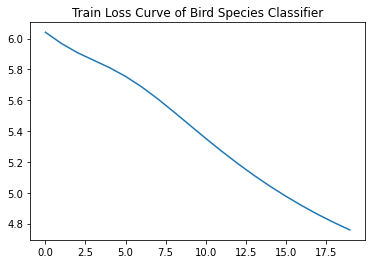

In [96]:
import matplotlib.pyplot as plt

train_losses = torch.tensor(train_losses, device = 'cpu')
plt.plot(np.arange(len(train_losses)), train_losses)
plt.title('Train Loss Curve of Bird Species Classifier')

Text(0.5, 1.0, 'Validation Accuracy Curve of Bird Species Classifier')

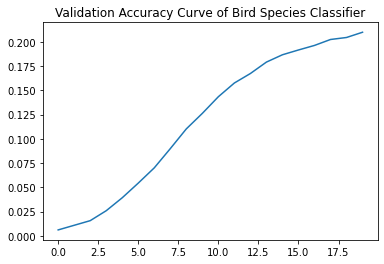

In [97]:
val_losses = torch.tensor(val_losses, device = 'cpu')
plt.plot(np.arange(len(val_losses)), val_losses)
plt.title('Validation Accuracy Curve of Bird Species Classifier')

Text(0.5, 1.0, 'Log-score Curve of Bird Species Classifier')

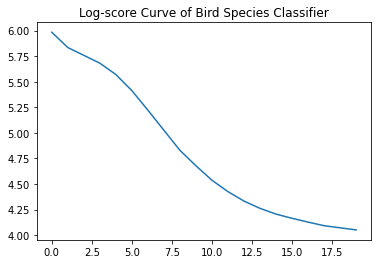

In [98]:
log_scores = torch.tensor(log_scores, device = 'cpu')
plt.plot(np.arange(len(log_scores)), log_scores)
plt.title('Log-score Curve of Bird Species Classifier')

Text(0.5, 1.0, 'F-beta score Curve of Bird Species Classifier')

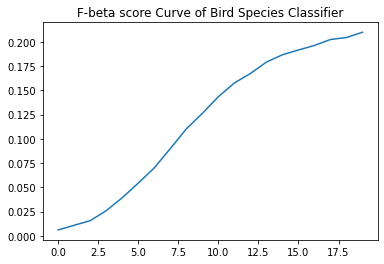

In [99]:
fbeta_scores = torch.tensor(fbeta_scores, device = 'cpu')
plt.plot(np.arange(len(fbeta_scores)), fbeta_scores)
plt.title('F-beta score Curve of Bird Species Classifier')

In [100]:
print('\nAccuracy: %.2f' % (100 * test_scores[0]))
print('Log Loss score:\t%.2f' % (test_scores[1]))
print('Fbeta-score (beta=1.0): \t%.2f' % (test_scores[2]))


Accuracy: 21.31
Log Loss score:	4.06
Fbeta-score (beta=1.0): 	0.21
